In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
import itertools
import math
import re
import lightgbm as lgb

In [2]:
train =pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/train.csv")
test=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/test.csv")
oil=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/oil.csv")
stores=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/stores.csv")
transactions=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/transactions.csv")
holidays=pd.read_csv("/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv")

In [3]:
train['test'] = 0
test['test'] = 1

data = pd.concat([train, test], axis=0)

In [4]:
data = data[data['date']>'2017-06-31']

In [5]:
data_ = data.copy().reset_index()

train = data_[data_['test'] == 0]
test = data_[data_['test'] == 1]

train['date'] = pd.to_datetime(train["date"])
train['day_of_week'] = train['date'].dt.day_of_week
# train['day_of_year'] = train['date'].dt.dayofyear
# train['day_of_month'] = train['date'].dt.day
# train['month'] = train['date'].dt.month
# train['quarter'] = train['date'].dt.quarter
train['year'] = train['date'].dt.year

/tmp/ipykernel_35/39225754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['date'] = pd.to_datetime(train["date"])
/tmp/ipykernel_35/39225754.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['day_of_week'] = train['date'].dt.day_of_week
/tmp/ipykernel_35/39225754.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [6]:
grouping_columns = ['year',  'day_of_week']

for ind, column in enumerate(grouping_columns):
    grouped_data = train.groupby(column)['sales'].sum()
    grouped_data = pd.DataFrame(grouped_data).reset_index()

In [7]:
data_ = data.copy().reset_index()
grouped_data = data_.groupby(['store_nbr', 'family'])

In [8]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1,7,30]

for a in alphas:
    for i in lags:
        data_[f'sales_lag_{i}_alpha_{a}'] = np.log1p(grouped_data['sales'].transform(lambda x: x.shift(i).ewm(alpha=a, min_periods=1).mean()))

data_['sales_lag_7_alpha_0.5'].describe()

count    98010.000000
mean         3.677854
std          2.493497
min          0.000000
25%          1.651584
50%          3.449374
75%          5.640374
max          9.923257
Name: sales_lag_7_alpha_0.5, dtype: float64

In [9]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110484 entries, 0 to 110483
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   index                    110484 non-null  int64  
 1   id                       110484 non-null  int64  
 2   date                     110484 non-null  object 
 3   store_nbr                110484 non-null  int64  
 4   family                   110484 non-null  object 
 5   sales                    81972 non-null   float64
 6   onpromotion              110484 non-null  int64  
 7   test                     110484 non-null  int64  
 8   sales_lag_1_alpha_0.95   108702 non-null  float64
 9   sales_lag_7_alpha_0.95   98010 non-null   float64
 10  sales_lag_30_alpha_0.95  57024 non-null   float64
 11  sales_lag_1_alpha_0.8    108702 non-null  float64
 12  sales_lag_7_alpha_0.8    98010 non-null   float64
 13  sales_lag_30_alpha_0.8   57024 non-null   float64
 14  sale

In [12]:
data_['date'] = pd.to_datetime(data_["date"])
data_['day_of_week'] = data_['date'].dt.day_of_week
# data_['day_of_year'] = data_['date'].dt.dayofyear
# data_['day_of_month'] = data_['date'].dt.day
# data_['month'] = data_['date'].dt.month
# data_['quarter'] = data_['date'].dt.quarter
data_['year'] = data_['date'].dt.year

In [13]:
data_['onpromotion'] = data_['onpromotion'].apply(lambda x: x > 0)

In [14]:
sales_lag_columns = list(data_.filter(like="lag").columns)

In [15]:
# data_ = data_.drop(['type_y', 'type_x','locale', 'locale_name', 'family', 'store_nbr','city', 'cluster'],axis=1)

In [16]:
training_percentage = 0.8
testing_percentage = 0.2

to_dummies = ['day_of_week', 'year',  'onpromotion']

X = data_.loc[:, [ 'day_of_week', 'year', 'onpromotion', 'test', 'sales', 'id']+ sales_lag_columns]
X[to_dummies] = X[to_dummies].astype('category')

data_train = X[X['test'] == 0]
data_test = X[X['test'] == 1]

n = len(data_train)

training_start = 0
training_end = math.floor(n * training_percentage)
validation_start = training_end
validation_end = n

X_train = data_train.loc[training_start:training_end, :].drop(['test', 'sales', 'id'],  axis=1)
y_train = data_train.loc[training_start:training_end, 'sales']
X_val = data_train.loc[validation_start:validation_end,  :].drop(['test', 'sales', 'id'],  axis=1)
y_val = data_train.loc[validation_start:validation_end, 'sales']

X_test = data_test.loc[:, ].drop(['test', 'sales', 'id'],  axis=1)

In [17]:
X_train = X_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) 
X_val = X_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) 
X_test = X_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) 

In [18]:
# Best parameters found: OrderedDict([('bagging_fraction', 0.8), ('bagging_freq', 10), ('feature_fraction', 0.8), ('learning_rate', 0.057093859214850086), ('max_bin', 512), ('max_depth', 35), ('num_leaves', 150)])
# Best score: -74891.06826911287

In [24]:
hyper_params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': 'rmse','learning_rate': 0.1,
'feature_fraction': 0.8000876448699572,'bagging_fraction': 0.8511341579856577,'bagging_freq': 5,'verbose': 0,"max_depth": 50,"num_leaves": 128,"max_bin": 512}
#feature_fraction is set=0.8000876448699572, prev= 0.9
#bagging_fraction is set=0.8511341579856577, prev= 0.7
#bagging_freq is set=5, prev=10

gbm = lgb.LGBMRegressor(**hyper_params)

gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='rmse')

[LightGBM] [Warning] feature_fraction is set=0.8000876448699572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000876448699572
[LightGBM] [Warning] bagging_fraction is set=0.8511341579856577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8511341579856577
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8000876448699572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000876448699572
[LightGBM] [Warning] bagging_fraction is set=0.8511341579856577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8511341579856577
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8000876448699572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000876448699572
[LightGBM] [Warning] bagging

LGBMRegressor(bagging_fraction=0.8511341579856577, bagging_freq=5,
              feature_fraction=0.8000876448699572, max_bin=512, max_depth=50,
              metric='rmse', num_leaves=128, objective='regression',
              task='train', verbose=0)

In [25]:
y_pred = gbm.predict(X_val)

[LightGBM] [Warning] feature_fraction is set=0.8000876448699572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000876448699572
[LightGBM] [Warning] bagging_fraction is set=0.8511341579856577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8511341579856577
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [26]:
from sklearn.metrics import mean_squared_log_error
y_val_non_negative = np.maximum(y_val, 0)
y_pred_non_negative = np.maximum(y_pred, 0)
rmsle = np.sqrt(mean_squared_log_error(y_val_non_negative, y_pred_non_negative))
print(f'RMSLE: {rmsle}')

RMSLE: 0.5989643976546003


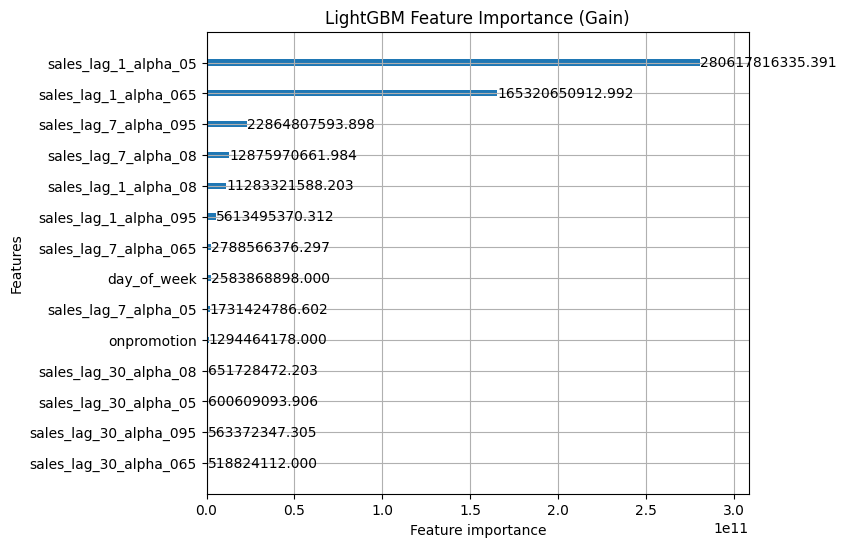

In [27]:
# Assuming you have already trained your model as shown in your code
# Plot feature importance using Gain
lgb.plot_importance(gbm, importance_type="gain", figsize=(7,6), title="LightGBM Feature Importance (Gain)")
plt.show()

Find the best Hyperparameter

In [30]:
results = pd.concat([y_val.reset_index(drop=True), pd.Series(y_pred)], axis=1).rename(columns={'sales': 'y_val', 0: 'y_pred'})

results['y_pred'] = results['y_pred'].clip(0)

results = results[results['y_val'] > 10]

results

,y_val,y_pred
0,20.000,27.226878
1,2258.000,2291.684652
2,2684.000,2568.090875
3,672.719,579.693536
4,603.000,556.692043
...,...,...
16390,438.133,406.914179
16391,154.553,114.167417
16392,2419.729,2513.766300
16393,121.000,193.677881


In [31]:
results['error'] = abs(results['y_pred'] - results['y_val'])

<Axes: >

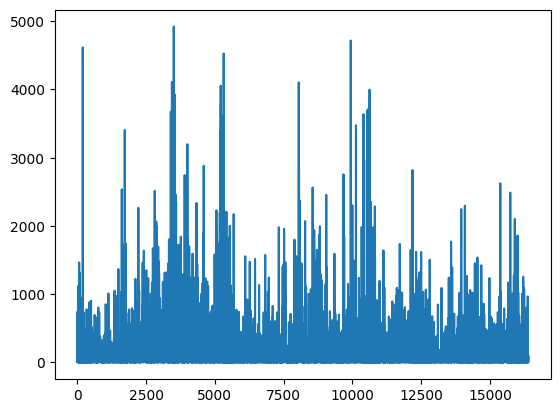

In [32]:
results['error'].plot()

In [33]:
y_pred = gbm.predict(X_test)
y_pred

[LightGBM] [Warning] feature_fraction is set=0.8000876448699572, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8000876448699572
[LightGBM] [Warning] bagging_fraction is set=0.8511341579856577, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8511341579856577
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


array([   3.22628184,    2.10382858,    6.96302717, ..., 1993.99756873,
        136.82590892,   15.31640667])

In [34]:
data_test['id']
output = pd.DataFrame(index=data_test['id'])
output['sales'] = y_pred
output['sales'] = output['sales'].clip(0)

In [35]:
output.to_csv('/kaggle/working/submission.csv')

In [36]:
# from lazypredict.Supervised import LazyRegressor
# from sklearn import datasets
# from sklearn.utils import shuffle
# import numpy as np
# boston = datasets.load_boston()
# X, y = shuffle(boston.data, boston.target, random_state=13)
# X = X.astype(np.float32)
# offset = int(X.shape[0] * 0.9)
# X_train, y_train = X[:offset], y[:offset]
# X_test, y_test = X[offset:], y[offset:]
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None )
# models,predictions = reg.fit(X_train, X_test, y_train, y_test)